Columns in DataFrame: Index(['gameId', 'duration', 'esportsTeamId_Blue', 'esportsTeamId_Red',
       'blue_totalGold', 'blue_inhibitors', 'blue_towers', 'blue_barons',
       'blue_totalKills', 'blue_dragons_count',
       ...
       'maxHealth_9', 'kills_9', 'deaths_9', 'assists_9', 'totalGoldEarned_9',
       'creepScore_9', 'killParticipation_9', 'championDamageShare_9',
       'wardsPlaced_9', 'wardsDestroyed_9'],
      dtype='object', length=166)
Columns after dropping unnecessary columns: Index(['gameId', 'duration', 'esportsTeamId_Blue', 'esportsTeamId_Red',
       'blue_totalGold', 'blue_inhibitors', 'blue_towers', 'blue_barons',
       'blue_totalKills', 'blue_dragons_count',
       ...
       'maxHealth_9', 'kills_9', 'deaths_9', 'assists_9', 'totalGoldEarned_9',
       'creepScore_9', 'killParticipation_9', 'championDamageShare_9',
       'wardsPlaced_9', 'wardsDestroyed_9'],
      dtype='object', length=126)
Columns after filling missing values: Index(['gameId', 'duration',

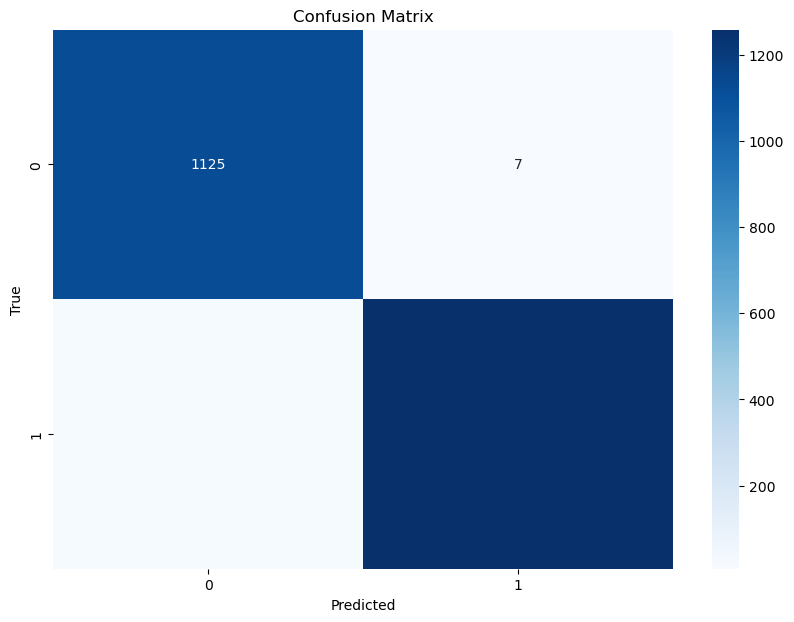

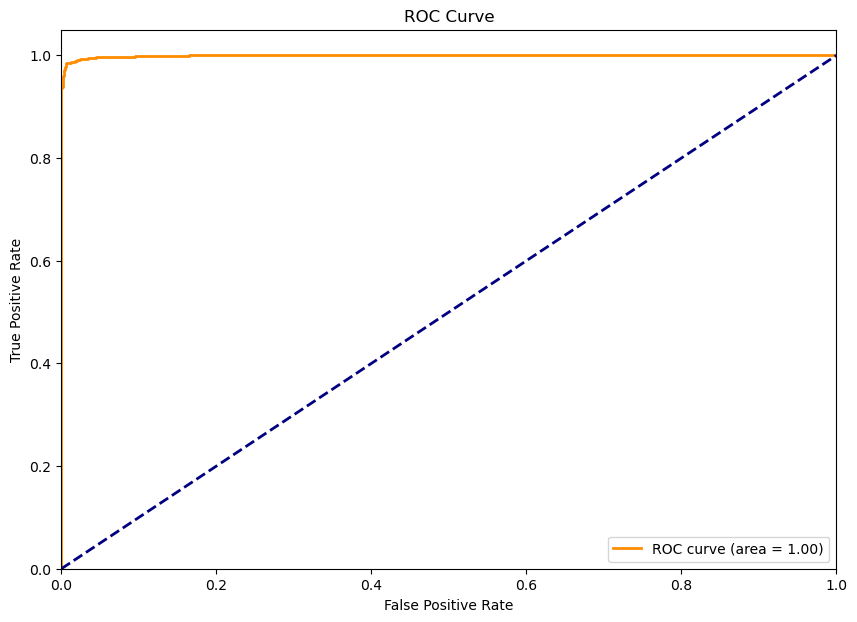

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1132
           1       0.99      0.98      0.99      1279

    accuracy                           0.99      2411
   macro avg       0.99      0.99      0.99      2411
weighted avg       0.99      0.99      0.99      2411



In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/last_row_of_collected_datas.xlsx')

# 데이터프레임의 열 이름 출력하여 확인
print("Columns in DataFrame:", df.columns)

# 필요 없는 열 제거
columns_to_drop = [col for col in df.columns if 'esportsPlayerId_' in col or 'teamCode_' in col or 'summonerName_' in col or 'championName_' in col]
df = df.drop(columns=columns_to_drop, errors='ignore')

# 데이터프레임의 열 이름 확인
print("Columns after dropping unnecessary columns:", df.columns)

# 결측값 처리
df.fillna(df.mean(), inplace=True)
print("Columns after filling missing values:", df.columns)

# 데이터 타입 확인
print("Data types:\n", df.dtypes)

# 범주형 데이터 추출
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
print("Initial Categorical Features:", categorical_features)

# 데이터 타입을 다시 한번 확인하고, 범주형 데이터가 문자열인지 확인
for col in categorical_features:
    if df[col].dtype != 'object':
        print(f"Column '{col}' is not object type, current type: {df[col].dtype}")

# 범주형 데이터가 아닌 경우, dtype을 확인하고 처리
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
print("Categorical Features after checking data types:", categorical_features)

# LabelEncoder 초기화
label_encoders = {col: LabelEncoder() for col in categorical_features}

# 범주형 데이터 변환
for col in categorical_features:
    df[col] = label_encoders[col].fit_transform(df[col])

# 범주형 열 확인
print("\nUpdated sample data in categorical features:")
for feature in categorical_features:
    print(f"\n{feature}:\n", df[feature].unique())

# 범주형 데이터와 숫자형 데이터 분리
numeric_features = [col for col in df.columns if col not in categorical_features and col != 'blue_totalGold' and col != 'red_totalGold']

print("Numeric Features:", numeric_features)

# 전처리기 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

# XGBoost 모델 정의
xgb_model = xgb.XGBClassifier(random_state=42)

# 모델 파이프라인 정의
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# 데이터 분할
X = df.drop(columns=['blue_totalGold', 'red_totalGold'], errors='ignore')
y = (df['blue_totalGold'] > df['red_totalGold']).astype(int)  # 승패를 이진화 (0: Red 승, 1: Blue 승)

# 데이터 분할 확인
print("X columns:", X.columns)
print("y distribution:", y.value_counts())

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률

# 정확도 출력
print('Accuracy:', accuracy_score(y_test, y_pred))

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# ROC 곡선 시각화 함수
def plot_roc_curve(y_true, y_score, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# 혼동 행렬 시각화
labels = [0, 1]  # 이진 분류에서의 클래스 레이블
plot_confusion_matrix(y_test, y_pred, labels)

# ROC 곡선 시각화
plot_roc_curve(y_test, y_score)

# 분류 리포트 출력
print(classification_report(y_test, y_pred))
